In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integrate
from scipy import stats
from scipy.optimize import minimize

In [1167]:
def function_normal(params):
    mu  = params[0]
    sigma = params[1]
    func = - (len(x)/2) * np.log(2*np.pi) - len(x) * np.log(sigma) - (1/(2*sigma**2)) * np.sum((x-mu)**2) + np.sum(np.log(stats.norm.cdf(y, loc = mu, scale = sigma)))
    return -func
initial_guess = np.array([0, 1])

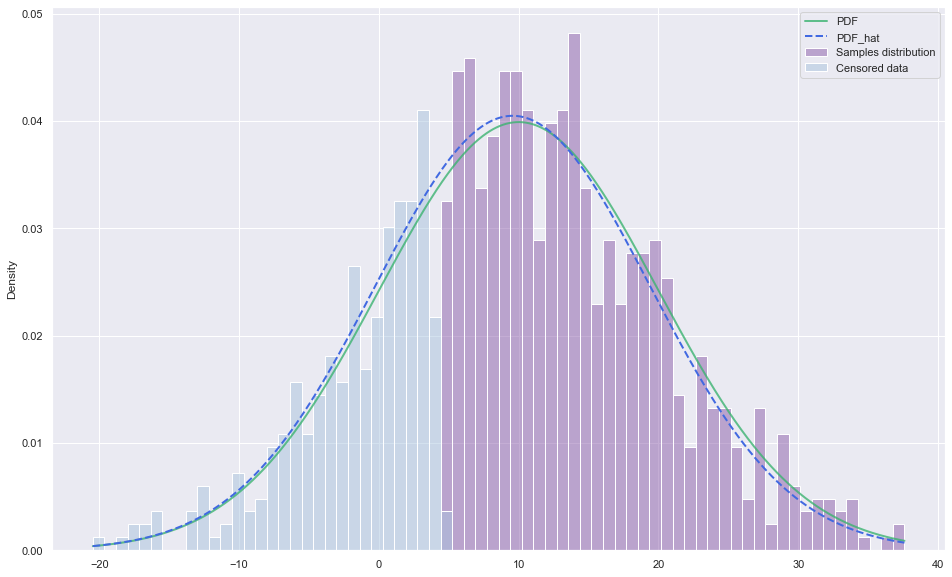

9.565548065277648 9.855526851187646


In [1169]:
np.random.seed(0)
fig, ax = plt.subplots(figsize = (16, 10))
sc = 10
q = 0.3
X = np.random.normal(loc = 10,scale = sc , size = 1000)
y = np.full((len(X[X<= np.quantile(X, q)]), ), np.quantile(X, q))
x = X[X>np.quantile(X, q)]
indicator = (X>np.quantile(X, q))
data = np.vstack([X,indicator]).T
data = pd.DataFrame(data, columns=['X', 'ind'])
bins = np.linspace(np.min(X), np.max(X), 1000)
pdf = stats.norm.pdf(bins, loc = 10, scale = sc)
x = np.sort(x)
sns.histplot(data = data, x = X,  bins = 70, stat = 'density', label = 'Distribution of samples', hue = 'ind', palette = 'BuPu', ax = ax)
ax.plot(bins, pdf, color = 'mediumseagreen', linewidth = 2, alpha = 0.8)
initial_guess = [0, 1]
mu, sigma = minimize(function_normal, initial_guess, bounds = ((-np.inf, np.inf), (0.01, 1000))).x
pdf_hat = stats.norm.pdf(bins, loc = mu, scale = sigma)
ax.plot(bins, pdf_hat, label="PDF_hat", color = 'royalblue', linewidth = 2, linestyle = '--')
ax.legend(labels = ['PDF', 'PDF_hat','Samples distribution', 'Censored data'])
plt.show()
print(mu, sigma)

In [1172]:
np.random.seed(1)
X = np.random.multivariate_normal(mean = np.array([10, 5]), cov = np.array([[3, 0.5], [0.5, 2]]), size = 10000)
data = X[X[:, 1]>np.quantile(X[:, 1], 0.1)]
cens = X[X[:, 1]<= np.quantile(X[:, 1], 0.1)]
cens[:, 1] = np.quantile(X[:, 1], 0.1)
cens[:, 0] = np.max(cens[:, 0])
def function_multi(params):
    mu_1 = params[0]
    mu_2 = params[1]
    var_1 = params[2]
    var_2 = params[3]
    cov = params[4]
    mean = np.array([mu_1, mu_2])
    matrix = np.array([[var_1, cov], [cov, var_2]])
    if np.linalg.det(matrix)>0:
        func = np.sum(np.log(stats.multivariate_normal.pdf(data, mean = mean, cov = matrix))) + np.sum(np.log(stats.multivariate_normal.cdf(cens, mean = mean, cov = matrix)))
        return -func
    else:
        return function_multi([0, 0, 1, 1, 0])
initial_guess = [0, 0, np.random.uniform(0.1,10), np.random.uniform(0.1,10), 1]
border = ((-100, 100), (-1000, 100), (0.1, 100), (0.01, 100), (-10, 10))
minimize(function_multi, initial_guess, bounds = border).x

array([9.96676363, 4.98646381, 2.99451416, 2.03706704, 0.55100133])

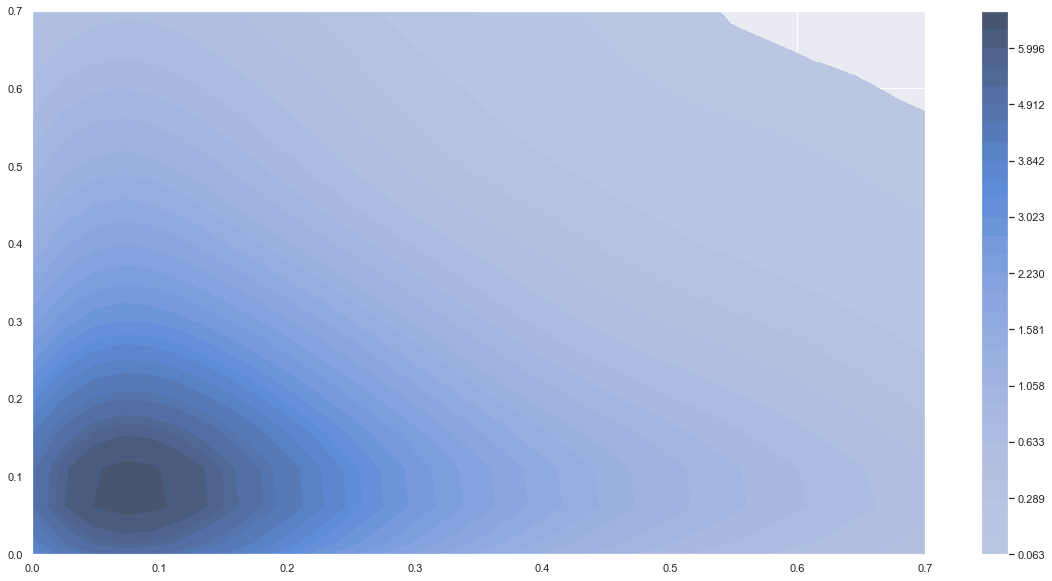

In [1173]:
data = np.random.pareto(size=(10000, 2),a=5)
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
sns.kdeplot(x = data[:, 0], y = data[:, 1], label='Pareto Distribution', levels = 30, fill = True, cbar = True, ax = ax)
ax.set_xlim(0, 0.7)
ax.set_ylim(0, 0.7)
plt.show();

In [1175]:
def function_pareto(params):
    alpha = params[0]
    gamma = params[1]
    sigma = params[2]
    pdf = (alpha*(alpha+1)*((gamma*sigma)**(alpha+1))) * ((sigma*x_obs + gamma * y_obs - gamma * sigma)**(-alpha-2))
    cdf = ((sigma*x_cens)**(alpha+1))*(sigma*x_cens + gamma * y_cens - gamma * sigma)**(-alpha-1)
    func = np.sum(np.log(pdf)) + np.sum(np.log(cdf))
    return -func

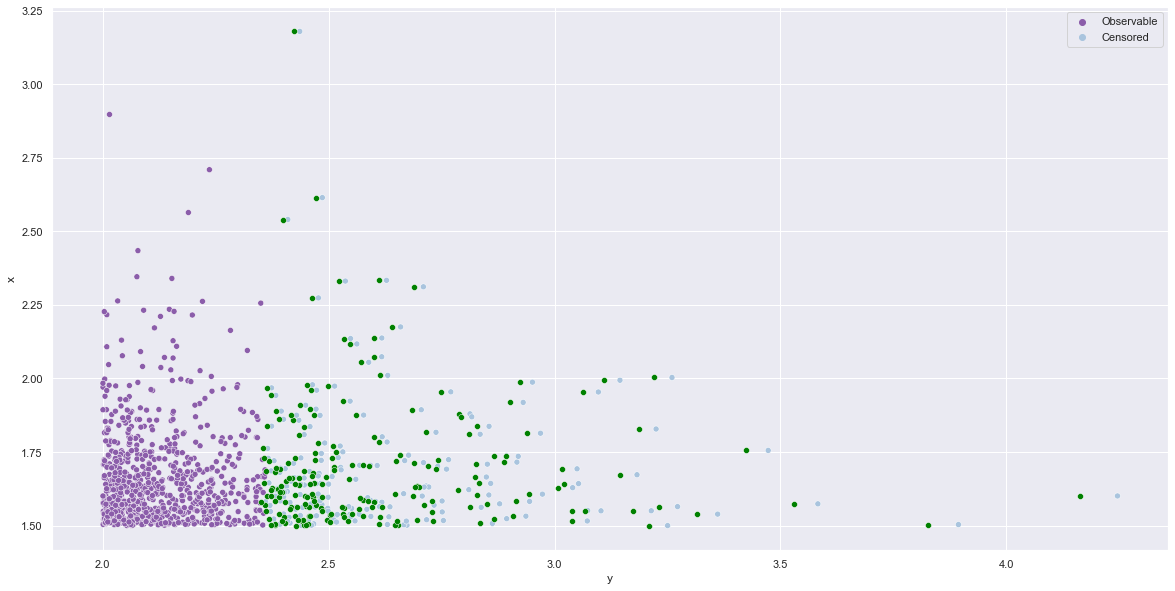

In [1176]:
np.random.seed(0)
u_x = np.random.uniform(0, 1, 1000)
u_y = np.random.uniform(0, 1, 1000)
a , gamma, sigma = [10, 1.5, 2]
x = gamma/u_x**(1/a)
y = sigma + sigma/gamma * x * (1/u_y**(1/(a+1)) - 1)
x_obs = x[y <= np.quantile(y,0.8)]
y_obs = y[y <= np.quantile(y,0.8)]
x_cens = x[y > np.quantile(y,0.8)]
y_cens = y[y > np.quantile(y,0.8)]
y_cens = np.full((200,), np.quantile(y,0.8))
initial_guess = [1, 1, 1]
borders = ((0.01, 100), (0.01, min(x)), (0.01, min(y_obs)))
alpha, gamma , sigma = minimize(function_pareto, initial_guess, bounds = borders, method = 'Nelder-mead').x
y_cens = sigma + sigma/gamma * x_cens * (1/u_y[y > np.quantile(y,0.8)]**(1/(alpha+1)) - 1)
ax = sns.scatterplot(x = y, y = x, hue = (y > np.quantile(y, 0.8)), palette = 'BuPu_r');
handles, labels  =  ax.get_legend_handles_labels()
ax_1 = sns.scatterplot(x = y_cens, y = x_cens, label = 'Model prediction', color = 'green')
ax.legend(handles, ['Observable', 'Censored'], loc='upper right')
handles, labels  =  ax_1.get_legend_handles_labels()
ax.set_xlabel('y')
ax.set_ylabel('x')
plt.show();